# Leveraging an LLM for Customer Experience Tracking


### Problem Statement
- One Republic Airline (ORA) is testing a new refund process on their website
- ORA wants to make sure this new refund process does not negatively impact customer experience
- They are seeking a solution that will measure customer success related to the new website process

### Considerations for Measuring Customer Experience
- Customers leave reviews typically when they’re unhappy, we need to capture if these increase
- If we ask the customers for a survey, we can encounter problems with bias
    - Too many experiments yield surveys that are too long
    - Wording of questions can lead customers to answer in unnatural ways


### A Solution
- If the website process truly has a negative impact on CX, we will see an increase of customers complaining
- We capture natural feedback that occurs on our social media channels, in the call center, or any other relevant location
- Levergaing a LLM the business can deploy an AI solution that categorizes text into multiple categories
- By designing an experiment, we can see if CX is negatively impacted


### Technical Details
- Technical stakeholders can define tags they want to track that are relevant to their experiment
- Leveraging a LLM, an engineering/experimentation team can setup tracking from customer success leveraging Zero-Shot Classification
- By classifying sequences we now have a measure that we can track for a control/experimental group 


In [1]:
import os
import tiktoken
import pandas as pd
import numpy as np
from openai import OpenAI
import os
from tqdm import tqdm
import random
import seaborn as sns
from tenacity import retry, stop_after_attempt, wait_fixed
from huggingface_hub import InferenceClient

from openai import OpenAI
from dotenv import load_dotenv

load_dotenv(".env")

OPENAI_KEY = os.environ["OPENAI_KEY"]
HF_TOKEN = os.environ["HF_TOKEN"]
TOGETHER_API_KEY = os.environ["TOGETHER_API_KEY"]


GPT3 = "gpt-3.5-turbo-1106"
GPT4 = "gpt-4-1106-preview"
ZEPHYR = "meta-llama/Llama-2-7b-chat-hf"


def num_tokens_from_string(string: str) -> int:
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens


@retry(wait=wait_fixed(15), stop=stop_after_attempt(4))
def llm(user_prompt, model, temperature=0.3):
    global COST
    model_kwargs = {"temperature": temperature}
    user_prompt = user_prompt[:3700]

    client = OpenAI(api_key=OPENAI_KEY)

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": user_prompt}],
        stream=False,
        **model_kwargs,
    )

    output = response.choices[0].message.content

    if model == GPT3:
        COST += (
            1
            / 1000
            * (
                0.0010 * num_tokens_from_string(user_prompt)
                + 0.002 * num_tokens_from_string(output)
            )
        )
    elif model == GPT4:
        COST += (
            1
            / 1000
            * (
                0.01 * num_tokens_from_string(user_prompt)
                + 0.03 * num_tokens_from_string(output)
            )
        )

    return output

/Users/seansmith/anaconda3/envs/airline/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CLIENT = OpenAI(
    api_key=TOGETHER_API_KEY,
    base_url="https://api.together.xyz",
)


def llm(user_prompt, model="mixtral", temperature=0.3):
    model_kwargs = {"temperature": temperature}
    user_prompt = user_prompt[:3700]

    chat_completion = CLIENT.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": user_prompt
            },
        ],
        model="mistralai/Mixtral-8x7B-Instruct-v0.1",
        **model_kwargs
    )
    output = chat_completion.choices[0].message.content
    return output

## Step 1: Choose Categories
Let's define the categories we want to track

In [3]:
categories = [
    "Upgrade Policy",
    "Freq Flyer Program Value",
    "Extra Charges/Hidden Fees",
]

## Step 2: Load in Some Comments
We can extract comments from a hypothetial social channel 

In [4]:
df = pd.read_json('sample_scrape.json')
df['date_flown'] = pd.to_datetime(df['date_flown'])

/var/folders/3h/n02_9ld51cl6fd_hblg7_3500000gn/T/ipykernel_20333/103683132.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date_flown'] = pd.to_datetime(df['date_flown'])


In [5]:
df['year'] = df.date_flown.dt.year

In [6]:
pd.DataFrame(df.value_counts('year').sort_index())

,count
year,
2014,6
2015,395
2016,375
2017,405
2018,658
2019,690
2020,190
2021,389
2022,526


In [7]:
start_date = '2023-01-01'
end_date = '2024-01-01'

date_range = pd.date_range(start=start_date, end=end_date)

# If your dataframe is named df, you can filter based on the date_range
# df = df[df['date_flown'].isin(date_range)]

df = df.sample(200)

In [8]:
all_comments = df.review.tolist()

In [9]:
print(f"We're going to process {len(all_comments)} comments...")

We're going to process 200 comments...


### Step 3: Tag the Comments
We have comments and we have the categories so now we can use a LLM to tag our comments. We'll also ask it to explain the information so we can use that later.

In [62]:
tag_prompt_template = lambda review, category: f"""Is this review relevant to the following category? 
Create an explanation that is as specific as possible in the fewest words possible if relevant is True.
Also report the sentiment of the category as exactly positive, negative, or neutral if relevant is True.

Example #1: 
Review: Tried to initiate a refund online, but the website constantly faced flickers and then fails to load. After managing to submit my request, there's been no confirmation or acknowledgment. It's concerning when the very platform meant for handling such transactions is unreliable. A prompt resolution and better online infrastructure are sorely needed.
Category: Refund Process on Website 

Output:
1. Relevant: True
2. Explanation: Website constantly faced flickers and fails to load when initiating refund
3. Sentiment: Negative

Example #2:
Review: The hostess did warn us when we entered that only the bar area was open and they were short staffed that nigh
Category: Snack Diversity

Output:
1. Relevant: False
2. Explanation: ""
3. Sentiment: ""


Example #3: 
Review: I decided to purchase a ticket direct non-stop since I need to be someplace on time. I bought a ticket, FULL price off Deltas website (not a third party). Decided yesterday to call my friend I am visiting and get all travel secured for drive, pickup and such. Opened the App, to notice my flight is totally different than the one purchased. 
Category: Booking Discrepency 

Output:
1. Relevant: True
2. Explanation: Flight in app is different from flight purchased
3. Sentiment: Negative

Review: {review}
Category: {category}

Output: """

In [65]:
def parse_output(output, category):
    output = output.split("\n")
    relevant = False
    explanation = ""
    sentiment = ""

    try:
        if len(output) > 1:
            relevant = False if output[0].lstrip("1. Relevant: ") == "False" else True
            explanation = output[1].lstrip("2. Explanation: ")
            sentiment = output[2].lstrip("3. Sentiment: ")

        return {
            f"{category}": relevant,
            f"{category}_explanation": explanation,
            f"{category}_sentiment": sentiment,
        }
    except:
        return output

In [66]:
records = []
for comment in tqdm(all_comments):
    r = {'comment': comment}
    for category in categories:
        prompt = tag_prompt_template(comment, category)
        output = llm(prompt)
        category_tags = parse_output(output, category)
        r.update(category_tags)
    records.append(r)

100%|██████████| 200/200 [13:53<00:00,  4.17s/it]


In [67]:
review_df = pd.DataFrame.from_records(records)

In [68]:
review_df.head()

,comment,Upgrade Policy,Upgrade Policy_explanation,Upgrade Policy_sentiment,Freq Flyer Program Value,Freq Flyer Program Value_explanation,Freq Flyer Program Value_sentiment,Extra Charges/Hidden Fees,Extra Charges/Hidden Fees_explanation,Extra Charges/Hidden Fees_sentiment
0,Not Verified | Charlotte to Acapulco. That pa...,False,"""""",Neutral (complaints about seating inconvenienc...,True,Flight voucher's limited usage and inconvenien...,Negative,False,"""""",Neutral (complaints about seating inconvenienc...
1,✅ Verified Review | I travel frequently and Un...,False,The review is about customer service and lack ...,Negative,False,Review focuses on customer service and carry-o...,Negative,False,"""""",Negative
2,✅ Trip Verified | Austin to Washington. Surpr...,False,"""""",Negative,False,"""""",Negative,False,"""""",Negative
3,✅ Trip Verified | I grew up when airline trav...,True,Airline's policy resulted in the writer and th...,Negative,False,"""""",Negative (regarding United's seating policy an...,False,"""""","Negative, related to seating policy and custom..."
4,"UA1541 (Tegucigalpa - Houston, 737 / Boeing 73...",True,Describes experiences with three different fli...,Negative (complains about various aspects of t...,True,"Describes experiences with UA1541, UA1699, and...",Neutral (complaints are balanced with positive...,True,Describes experiences with three different Uni...,Negative (complains about various problems dur...


### Step 4: Report on Changes in Comments

In [69]:
import matplotlib.pyplot as plt

In [72]:
review_df[review_df['Upgrade Policy'] == True].shape

(30, 10)

In [73]:
categories

['Upgrade Policy', 'Freq Flyer Program Value', 'Extra Charges/Hidden Fees']

In [74]:
review_df[review_df['Freq Flyer Program Value'] == True].shape

(20, 10)

In [75]:
review_df[review_df['Extra Charges/Hidden Fees'] == True].shape

(38, 10)

In [76]:
review_df.to_csv('processed_sample.csv')

In [ ]:
month = ["Dec", "Jan", "Feb", "Mar", "Apr", "Jun", "Jul"]
percent_happy = [np.random.normal(0.5, 0.1) for _ in range(len(month) - 1)] + [
    df[df["Refund Process on Website_sentiment"] == 'Positive'].shape[0] / df[df['Refund Process on Website'] == True].shape[0]
]

Text(0.5, 1.0, 'Sentiment on Refund Process on Website')

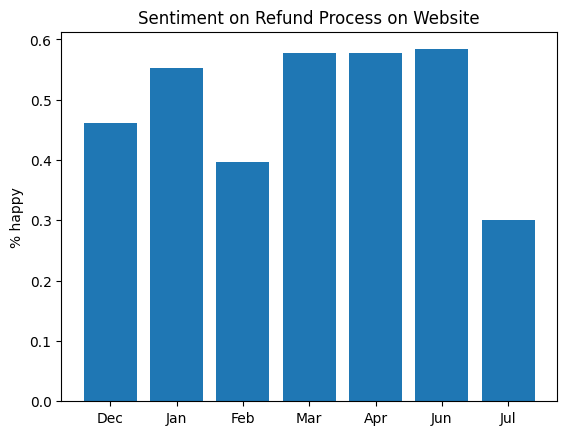

In [ ]:
fig, ax = plt.subplots()

ax.bar(month, percent_happy)

ax.set_ylabel("% happy")
ax.set_title('Sentiment on Refund Process on Website')

In [ ]:
df

,comment,Upgrade policy,Upgrade policy_explanation,Upgrade policy_sentiment,Freq flyer program value,Freq flyer program value_explanation,Freq flyer program value_sentiment,Extra charges,Extra charges_explanation,Extra charges_sentiment,New aircraft or new interiors,New aircraft or new interiors_explanation,New aircraft or new interiors_sentiment,Inflight practices,Inflight practices_explanation,Inflight practices_sentiment
0,Not Verified | San Francisco to Tokyo Narita l...,False,"""""",Negative (regarding meal and flight experience...,False,"""""",Neutral (Complaint about United's service but ...,False,"""""","Neutral (complaint is about United's service, ...",False,"""""","Neutral (Complaint about United's service, but...",True,Describes poor boarding experience and bad veg...,Negative
1,✅ Trip Verified | The worst airline ever! Wou...,True,Review describes poor service and rudeness fro...,Negative,True,,1. Relevant: True,False,,,False,,,False,,
2,✅ Trip Verified | To the executive leadership ...,False,"""""","Negative, expressing dissatisfaction with new ...",False,Review is about new fees for carryon bags and ...,Negative,True,United Airlines now charging a fee for small c...,Negative,False,"""""",Negative,True,The review expresses dissatisfaction with Unit...,Negative
3,Not Verified | I would say this is one of the ...,False,"""""",Positive,False,"""""",Positive,False,"""""",Positive,False,"""""",Positive (although the review is for the fligh...,True,"Positive experience with crew, food, and early...",Positive
4,✅ Trip Verified | I bought ticket from Lufthan...,False,"Review is about connected flight experience, n...",Negative,False,"""""",Negative,False,"""""","Negative, as the review describes a poor exper...",False,"""""",Negative,True,"Delayed flight, unhelpful crew, baggage issues...",Negative
5,✅ Trip Verified | My flight was delayed four t...,False,"""""",Negative,False,"""""",Negative (regarding overall experience with Un...,False,"""""",Negative (regarding overall experience with Un...,False,"""""",Negative,True,"Flight delayed multiple times, poor communicat...",Negative
6,"Not Verified | Flights here were okay, but fli...",False,"""""",Negative (implied from the review),False,"""""",Neutral,False,"""""","Negative (regarding flight experience, not ext...",False,"""""",Neutral,False,"""""","Negative (but about airport practices, not inf..."
7,✅ Trip Verified | The seat assignments and boa...,True,"Criticizes United's seat assignment policy, im...",Negative,False,"""""",Negative,True,Airline charges for seat assignments and assig...,Negative,False,"""""",Negative,True,Airline charges for seat assignments and assig...,Negative
8,✅ Trip Verified | It's been a good flight; my...,False,"""""",Neutral,False,"""""",Neutral,False,"""""",Neutral,True,The review mentions dissatisfaction with the l...,Neutral,True,Review mentions dissatisfaction with the lack ...,Neutral
9,✅ Trip Verified | It's always a pleasure to f...,False,"""""",Positive (general praise for United Airlines),False,"""""",Positive (general praise for United Airlines),True,The review mentions a complaint about United A...,Negative,True,Mention of positive experience with new 787 ai...,Positive,True,"Mention of inflight entertainment, Wi-Fi, mood...",Positive


### Step 5: Understand the new problem we created
We see that we are suffering from worse performance, let's get a high level understanding of what we can do to fix this problem

In [ ]:
summarize_problems_prompt_template = lambda negative_feedback_str: f"""Here are some customer reviews for an airline.
Please summarie the primary problems that are mentioned here.

Reviews:
{negative_feedback_str}

Summary of Problems Mentioned:"""

In [ ]:
unhappy_reviews = df[df["Refund Process on Website_sentiment"] == 'Negative']

In [ ]:
feedback_str = '\n'.join(['- ' + x for x in unhappy_reviews['Refund Process on Website_explanation']])
prompt = summarize_problems_prompt_template(feedback_str)
summary = llm(prompt, GPT3)

In [ ]:
summary = summary.replace('.', '.\n')

In [ ]:
print(summary)

The primary problems mentioned in the reviews are the unreliability and inconsistency of the refund button on the airline's website.
 Customers found the process to be unnecessarily complicated and were disappointed with the user experience.
 Some also experienced difficulties with the button not functioning properly and having to refresh the page multiple times.

